In [1]:
%pip install opencv-python tqdm pandas matplotlib torch torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm5.6
%pip install torchinfo
!source ~/.bashrc

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/rocm5.6
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2 as cv

# Color_img = os.listdir("./Train_K/color_full/")
# for img in Color_img:
#     try:
#         image = cv.imread(f'./Train_K/color_full/{img}')
#         SE = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7,7))
#         background = cv.morphologyEx(image, cv.MORPH_DILATE, SE)
#         image = cv.divide(image, background, scale=255)
#         image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
#         cv.imwrite(f"./Train_K/color_BW/{img}", image)
#     except: pass



# imgs = os.listdir("./Train_K/color_BW/")

# with open("./images_Train_K.csv", "w", newline='') as csvfile:
#     for img in imgs:
#         csvfile.writelines(f"{img}\n")
        
            

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image, ImageReadMode
from torchinfo import summary
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 4
IMG_SHAPE = (128, 128)

#On crée un dataset custom à partir des images du dossier 'dataset'
class TrainDataset(Dataset):
    def __init__(self, img_csv, img_size):
        self.img_csv = pd.read_csv(img_csv)
        self.transform = transforms.Resize(img_size)

    def __len__(self):
        return len(self.img_csv)

    def __getitem__(self, index):
        img_name = self.img_csv.iloc[index, 0]
        image = [read_image(f"./Train_K/color_BW/{img_name}"), read_image(f"./Train_K/color_full/{img_name}", ImageReadMode.RGB)]
        # On reshape les données :

        image = [self.transform(img) for img in image]

        #On normalise les données
        image = [(img - 127.5)/127.5 for img in image]disable igpu
        return image[0], image[1]


training_data = TrainDataset('./images_Train_K.csv', IMG_SHAPE)

#On charge notre dataset dans un dataloader
x_train = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle = True)

print(len(x_train))
for img in x_train:
    print(img[0].shape)
    break

14640
torch.Size([4, 1, 128, 128])


/home/aul16/Data/Documents/Coding/IA/Colorisation/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


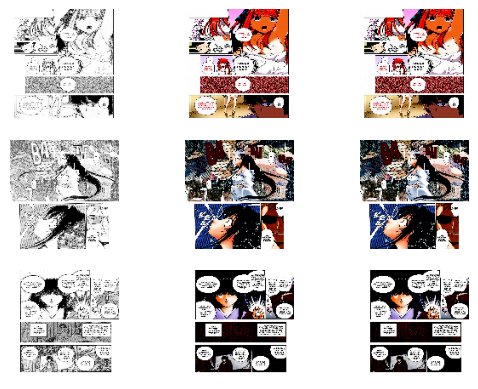

In [ ]:

for i,(img, gray_img) in enumerate(x_train):
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(img[0].permute(1, 2, 0), cmap="gray")
    plt.axis('off')
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(gray_img[0].permute(1,2,0))
    plt.axis('off')
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(gray_img[0].permute(1,2,0))
    plt.axis('off')
    if i >= 2:
        break
    

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.batch3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.batch4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.batch5 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        out1 = self.batch1(x)
        x = self.relu(out1)
        x = self.conv2(x)
        out2 = self.batch2(x)
        x = self.relu(out2)
        x = self.conv3(x)
        out3 = self.batch3(x)
        x = self.relu(out3)
        x = self.conv4(x)
        out4 = self.batch4(x)
        x = self.relu(out4)
        x = self.conv5(x)
        out5 = self.batch5(x)

        return [out1, out2, out3, out4, out5]

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.convT1 = nn.ConvTranspose2d(512, 512, 3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(1024, 512, 3, stride=1, padding=1)
        self.convT2 = nn.ConvTranspose2d(512, 256, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(512, 256, 3, stride=1, padding=1)
        self.convT3 = nn.ConvTranspose2d(256, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(256, 128, 3, stride=1, padding=1)
        self.convT4 = nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 3, 3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, *encoder_out):
        x = self.convT1(encoder_out[-1])
        x = self.relu(x)
        x = torch.cat((x, encoder_out[-2]), dim=1)
        x = self.conv1(x)
        x = self.relu(x)

        x = self.convT2(x)
        x = self.relu(x)
        x = torch.cat((x, encoder_out[-3]), dim=1)
        x = self.conv2(x)
        x = self.relu(x)

        x = self.convT3(x)
        x = self.relu(x)
        x = torch.cat((x, encoder_out[-4]), dim=1)
        x = self.conv3(x)
        x = self.relu(x)

        x = self.convT4(x)
        x = self.relu(x)
        x = torch.cat((x, encoder_out[-5]), dim=1)
        x = self.conv4(x)
        x = self.relu(x)

        return x

In [ ]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.loss = nn.MSELoss()

    def forward(self, x):
        encoder_out = self.encoder(x)
        x = self.decoder(*encoder_out)
        return x

In [ ]:
model = Unet()

In [ ]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epoch = 10
for i in range(epoch):
    for j, batch in tqdm(enumerate(x_train)):
        
        optimizer.zero_grad()
        x, y = batch
        y_hat = model(x)
        loss = loss_function(y_hat, y)*100
        loss.backward()
        optimizer.step()
        if j % 100 == 0:
            print(f"Loss : {loss.item()}")
            plt.subplot(3, 3, 1)
            plt.imshow(x[0].cpu().permute(1, 2, 0).detach().numpy(), cmap="gray")
            plt.title('Input Image')
            plt.axis('off')
            plt.subplot(3, 3, 2)
            plt.imshow(y[0].cpu().permute(1,2,0).detach().numpy())
            plt.title('Ground Truth')
            plt.axis('off')
            plt.subplot(3, 3, 3)
            plt.imshow(y_hat[0].cpu().permute(1,2,0).detach().numpy())
            plt.title('Predicted Image')
            plt.axis('off')
            plt.show()
    print(f"Epoch {i+1}/{epoch} terminée, Loss : {loss.item()}")


0it [00:00, ?it/s]/home/aul16/Data/Documents/Coding/IA/Colorisation/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
0it [00:17, ?it/s]


RuntimeError: HIP error: the operation cannot be performed in the present state
HIP kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing HIP_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_HIP_DSA` to enable device-side assertions.


5.6.31061-8c743ae5d
